In [2]:
#
# In this notebook we exampine moprhology's rol,e of preicpitaiton system
#
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from global_land_mask import globe
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats import binned_statistic, binned_statistic_2d, pearsonr, linregress
from src.regions import *
from src.pf_stats import *
from src.plotting import *
from src.radar import *

## Looking at vertical radar contours

In [3]:
CORE_THRESH = 10
regions = [
    cio_region(), 
    wmp_region(), 
    sas_region()
]

In [4]:
pf_stats_dict = {r.name: load_pf_stats(r, maxpr_min=CORE_THRESH, just_tropics=False, trim_region=True) for r in regions}

In [5]:
radar_dict = {r.name: load_merged_radar(r, trim_region=True, maxpr_min=CORE_THRESH)[['max_precip_refl', 'rainiest_10mmhr_cluster_refl_conn8']] for r in regions}

In [6]:
maritime_continent_data = {
    'mc_pf_stats': [],
    'mc_radar': []
}
for r, data in pf_stats_dict.items():
    print(r)

    MC_mask = (
         (data['mean_longitude'] <= 170)
         & (data['mean_longitude'] >= 90)
         & (abs(data['mean_latitude'] <= 20))
    )

    maritime_continent_data['mc_pf_stats'].append(data[MC_mask])
    maritime_continent_data['mc_radar'].append(radar_dict[r].isel(features=np.where(MC_mask)[0]))
    
   
maritime_continent_data['mc_pf_stats'] = pd.concat(maritime_continent_data['mc_pf_stats'])
maritime_continent_data['mc_radar'] = xr.concat(maritime_continent_data['mc_radar'], dim='features')

CIO
WMP
SAS


In [7]:
area = maritime_continent_data['mc_pf_stats']['num_pixels'] * 25

core_area = maritime_continent_data['mc_pf_stats']['largest_10mmhr_cluster_size_8conn'] * 25

loc = (
    maritime_continent_data['mc_pf_stats']['largest_10mmhr_cluster_precip_8conn']
    /maritime_continent_data['mc_pf_stats']['total_precip']
)

radar_profs = maritime_continent_data['mc_radar']['max_precip_refl']

In [8]:
np.nanmin(np.log10(radar_profs)*10)

12.100000381469727

/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))
/Users/pedro/miniconda3/envs/extreme_precipitation_in_gpm/lib/python3.12/site-packages/scipy/stats/_binned_statistic.py:694: RuntimeWarning: Mean of empty slice
  stat = stat_func(np.array(bin_map[i]))


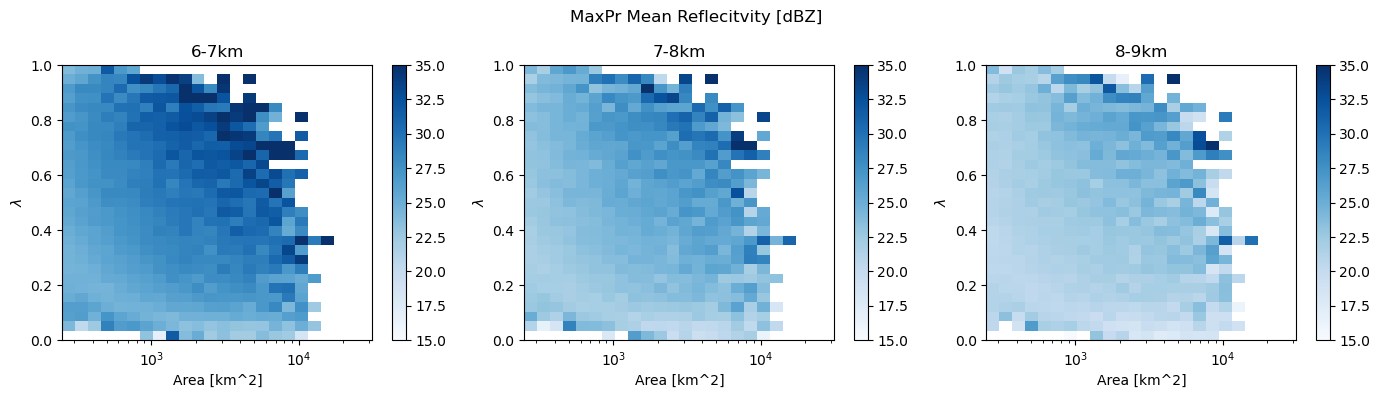

In [14]:
#
# Plot the layer mean reflectivity
#
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(14, 4))

# area = pf_stats['num_pixels'] * 25
# loc = pf_stats[f'rainiest_{CORE_THRESH}mmhr_cluster_precip_8conn']/pf_stats['total_precip']
area_bins = np.logspace(np.log10(250), 4.5, 25)
loc_bins = np.linspace(0, 1, 30)

layer_slices = [slice(6, 7), slice(7, 8), slice(8,9)]
norm_list = [
    colors.Normalize(vmin=15, vmax=35), 
    colors.Normalize(vmin=15, vmax=35), 
    colors.Normalize(vmin=15, vmax=35)
]
for i, (ax, norm) in enumerate(zip(axs.ravel(), norm_list)):
    mean_z = radar_profs.sel(alt=layer_slices[i]).mean('alt', skipna=True)
    mean = binned_statistic_2d(
        loc, 
        area, 
        bins=[loc_bins, area_bins],
        values=np.log10(mean_z) * 10,  # convert reflectivity
        statistic=np.nanmean
    ).statistic
    
    x_mesh, y_mesh = np.meshgrid(area_bins, loc_bins)
    c = ax.pcolormesh(
        x_mesh, 
        y_mesh, 
        mean,
        cmap=plt.cm.Blues, 
        norm=norm
    )
    # Add colorbar
    cb = fig.colorbar(c, ax=ax)
    # cb.ax.set_xlabel('[dBZ]')
    
    # Label axes & title
    ax.set_xscale('log')
    ax.set_xlabel('Area [km^2]')
    ax.set_ylabel(r'$\lambda$')
    ax.set_title(f"{layer_slices[i].start}-{layer_slices[i].stop}km")
    # ax.set_title(chr(ord('a') + i), loc='left')

fig.suptitle('MaxPr Mean Reflecitvity [dBZ]')
fig.tight_layout(pad=1)

save_figure(fig, 'Mean Reflecitivity')